In [1]:
import scipy as sp
import numpy as np
import pandas as pd
from numpy.random import rand
pd.options.display.max_colwidth = 600

# Scikit Imports
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split

# import cnn_utils as utils
# from model_evaluation_utils import get_metrics

# Matplot Imports
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)
%matplotlib inline

# pandas display data frames as tables
from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

In [2]:
sp.__version__

'1.4.1'

In [3]:
import tensorflow as tf
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import Model
from tensorflow.keras.applications import vgg16 as vgg
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.utils 
import np_utils

In [4]:
# import tensorflow as tf
from tensorflow.keras.utils import to_categorical

In [5]:
BATCH_SIZE = 64
EPOCHS = 30
NUM_CLASSES = 10
# 1e-4 = 0.0001
LEARNING_RATE = 1e-4
MOMENTUM = 0.9

In [36]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [37]:
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.15, 
                                                  stratify=np.array(y_train), 
                                                  random_state=42)

In [42]:
# This is one-hot encoding
Y_train = to_categorical(y_train, NUM_CLASSES)
Y_val = to_categorical(y_val, NUM_CLASSES)
Y_test = to_categorical(y_test, NUM_CLASSES)
print(Y_train[:5])

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


In [9]:
# min size that VGG16 takes is 48.
import cv2


X_train = np.array([cv2.resize(x, (48, 48)) for x in X_train])
X_val = np.array([cv2.resize(x, (48, 48)) for x in X_val])
X_test = np.array([cv2.resize(x, (48, 48)) for x in X_test])


# height = 256
# width  = 256
# ...
# img_array = cv2.imread((train_dir+str(img_name)+".png"))
# new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE),3)
# img = ...
# img = np.array(Image.fromarray(img).resize(height, width), PIL.Image.BILINEAR).astype(np.double)


### Prepare the Model
Load VGG16 without the top classification layer

Prepare a custom classifier

Stack both models on top of each other

In [10]:
base_model = vgg.VGG16(weights='imagenet', 
                       include_top=False, 
                       input_shape=(48, 48, 3))

58892288/58889256 [==============================] - 1s 0us/step


In [11]:
# Extract the last layer from third block of vgg16 model
last = base_model.get_layer('block3_pool').output

In [12]:
# Add classification layers on top of it
x = GlobalAveragePooling2D()(last)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
pred = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(base_model.input, pred)

Since our objective is to only train the custom classifier, we freeze the layers of VGG16

**Why do we freeze the layers ?**

Layer freezing means layer weights of a trained model are not changed when they are reused in a subsequent downstream task - they remain frozen. Essentially when backprop is done during training these layers weights are untouched.

link: https://www.quora.com/What-is-layer-freezing-in-transfer-learning

In [13]:
for layer in base_model.layers:
     layer.trainable = False

In [14]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

### **Data Augmentation**

In [16]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=False)

In [17]:
train_datagen.fit(X_train)
train_generator = train_datagen.flow(X_train,
                                     Y_train, 
                                     batch_size=BATCH_SIZE)

In [18]:
val_datagen = ImageDataGenerator(rescale=1. / 255,
    horizontal_flip=False)

val_datagen.fit(X_val)
val_generator = val_datagen.flow(X_val,
                                 Y_val,
                                 batch_size=BATCH_SIZE)

**Train the Model**

In [19]:
train_steps_per_epoch = X_train.shape[0] // BATCH_SIZE
val_steps_per_epoch = X_val.shape[0] // BATCH_SIZE

history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=EPOCHS,
                              verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
664/664 [==============================] - 21s 31ms/step - loss: 1.7664 - accuracy: 0.3819 - val_loss: 1.2842 - val_accuracy: 0.5681
Epoch 2/30
664/664 [==============================] - 20s 31ms/step - loss: 1.3433 - accuracy: 0.5365 - val_loss: 1.0963 - val_accuracy: 0.6298
Epoch 3/30
664/664 [==============================] - 20s 31ms/step - loss: 1.1820 - accuracy: 0.5915 - val_loss: 1.0014 - val_accuracy: 0.6607
Epoch 4/30
664/664 [==============================] - 21s 31ms/step - loss: 1.0979 - accuracy: 0.6202 - val_loss: 0.9436 - val_accuracy: 0.6765
Epoch 5/30
664/664 [==============================] - 21s 31ms/step - loss: 1.0303 - accuracy: 0.6437 - val_loss: 0.9016 - val_accuracy: 0.6896
Epoch 6/30
664/664 [==============================] - 20s 31ms/step - loss: 0.9821 - accuracy: 0.6619 - val_loss: 0.8688 - val_accuracy: 0.6976
Epoch 7/30
664/664 [==============================] - 21s 31

Analyze Model Performance



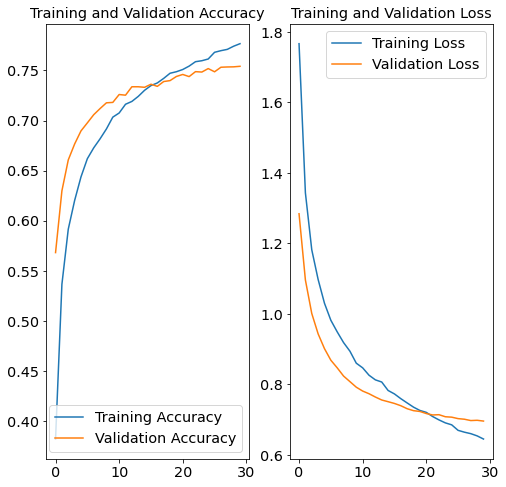

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [33]:
predictions = model.predict(X_test/255.)

In [43]:
test_labels = list(y_test.squeeze())
predictions = list(predictions.argmax(axis=1))

In [44]:
catagories = {'dog': 0,'automobile': 1,'bird': 2,'cat': 3,'deer': 4,'airplane': 5,'frog': 6,'horse': 7,'ship': 8,'truck': 9}
reverse_catagory = {n:i for i,n in catagories.items()}
print(reverse_catagory)

{0: 'dog', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'airplane', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


In [45]:
test_dataset = [reverse_catagory[name] for name in test_labels]
print(test_dataset[:5])

['cat', 'ship', 'ship', 'dog', 'frog']


In [46]:
prediction_dataset = [reverse_catagory[name] for name in predictions]
print(prediction_dataset[:5])

['cat', 'ship', 'ship', 'dog', 'frog']


In [47]:
final_dataset = pd.DataFrame({"Actual":test_dataset,"Prediction":prediction_dataset})
final_dataset.head()

,Actual,Prediction
0,cat,cat
1,ship,ship
2,ship,ship
3,dog,dog
4,frog,frog
